In [67]:
import pandas as pd
import time
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tools.eval_measures import mse as sm_mse, rmse as sm_rmse, meanabs as sm_mae
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, TFT, PatchTST, TCN, DLinear, RNN, LSTM, Autoformer, BiTCN, DeepAR, DeepNPTS, DilatedRNN, FEDformer, GRU, HINT, Informer, iTransformer, KAN, MLP, MLPMultivariate, NBEATSx, NLinear, RMoK, SOFTS, StemGNN, TiDE, TimeMixer, TimeLLM, TimesNet, TSMixer, TSMixerx, VanillaTransformer
from neuralforecast.losses.pytorch import MQLoss

from neuralforecast.utils import AirPassengersDF
import time
import pandas as pd
import numpy as np
import torch
torch.set_float32_matmul_precision('high')  # or 'medium' for more precision

import plotly.graph_objects as go
from sklearn.utils import check_random_state
import logging
logging.basicConfig(level=logging.INFO)
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random_state = check_random_state(seed)

In [68]:
req_naics = 336111
df = pd.read_csv(f"../data/processed_data_{req_naics}.csv")

In [69]:
import sys
print(sys.version)
print(sys.executable)

3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
/opt/conda/envs/ai_env/bin/python


In [70]:
df.head()

,year,naics,emp,pay,prode,prodh,prodw,vship,matcost,vadd,...,equip,plant,piship,pimat,piinv,pien,dtfp5,tfp5,dtfp4,tfp4
0,1958,336111,146.1,868.4,116.2,229.7,650.6,5007.9,3411.3,1563.8,...,3291.1,11718.8,0.314,0.238,0.180,0.147,NaN,0.553,NaN,0.550
1,1959,336111,160.6,1072.6,131.0,283.2,827.2,6422.2,4306.7,2143.4,...,3457.5,11415.6,0.322,0.243,0.184,0.145,0.052,0.583,0.053,0.580
2,1960,336111,176.1,1183.7,144.7,302.8,925.7,7239.0,4883.5,2336.2,...,3673.0,11375.1,0.318,0.241,0.190,0.150,0.030,0.601,0.030,0.598
3,1961,336111,152.4,1035.7,123.2,252.9,789.5,6214.2,4134.9,2053.6,...,3794.2,11179.9,0.317,0.242,0.190,0.146,-0.007,0.596,-0.009,0.592
4,1962,336111,168.2,1223.6,138.4,297.1,954.7,7855.3,5187.9,2671.2,...,3908.1,11141.2,0.315,0.246,0.193,0.147,0.077,0.644,0.078,0.641


In [71]:
df.tail()

,year,naics,emp,pay,prode,prodh,prodw,vship,matcost,vadd,...,equip,plant,piship,pimat,piinv,pien,dtfp5,tfp5,dtfp4,tfp4
56,2014,336111,75.4,5713.8,64.2,130.7,4460.5,124061.4,98320.1,26044.6,...,24935.6,11007.2,1.029,1.008,1.018,1.215,-0.006,0.982,-0.006,0.982
57,2015,336111,78.2,6091.3,67.2,140.0,4795.8,124761.4,100587.8,24187.1,...,27070.7,11273.6,1.053,1.011,1.017,1.133,-0.047,0.937,-0.047,0.937
58,2016,336111,82.4,6382.8,71.1,144.5,5089.4,129996.2,102697.8,26941.9,...,28998.7,11625.9,1.062,1.003,1.015,1.126,0.000,0.937,0.000,0.937
59,2017,336111,80.8,6564.1,63.1,119.6,4596.1,99360.9,79653.3,19730.2,...,NaN,NaN,1.076,1.009,NaN,1.251,NaN,NaN,NaN,NaN
60,2018,336111,81.9,6672.1,63.1,124.2,4640.8,104986.8,85576.6,19488.4,...,NaN,NaN,1.084,1.025,NaN,1.274,NaN,NaN,NaN,NaN


In [72]:
# Convert 'Year' column to datetime if it's not already
df['ds'] = pd.to_datetime(df['year'], format='%Y')
df['unique_id'] = "all"
df = df.rename(columns={"vship": "y"}) 
df = df[["unique_id", "ds", "y"]] 
# Select the column to decompose (e.g., 'VSHIP' for turnover forecasting)
# series = df[['vship', '', '']]  # Replace with the relevant column

In [73]:
# Train-test split
test_size = int(len(df) * 0.1)
train = df[:len(df) - test_size]
val = df[len(df) - test_size:]

# Confirm split integrity
print(f"Data split: Total: {len(df)}, Train: {len(train)}, Test: {len(train)}")
print("Training set date range:", train['ds'].min(), "to", train['ds'].max())
print("Testing set date range:", val['ds'].min(), "to", val['ds'].max())
train.set_index('ds', inplace=False)
val.set_index('ds', inplace=False)

Data split: Total: 61, Train: 55, Test: 55
Training set date range: 1958-01-01 00:00:00 to 2012-01-01 00:00:00
Testing set date range: 2013-01-01 00:00:00 to 2018-01-01 00:00:00


,unique_id,y
ds,,
2013-01-01,all,115122.9
2014-01-01,all,124061.4
2015-01-01,all,124761.4
2016-01-01,all,129996.2
2017-01-01,all,99360.9
2018-01-01,all,104986.8


In [74]:
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tools.eval_measures import mse as sm_mse, rmse as sm_rmse, meanabs as sm_mae

# Custom SMAPE function
def smape_loss(y_true, y_pred):
    y_true = y_true.values
    y_pred = y_pred.values
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Function to evaluate models (Now includes MASE from statsmodels)
def evaluate_model(y_true, y_pred, y_train, model_name, start_time):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = smape_loss(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Compute MASE using statsmodels mean absolute error
    naive_forecast_errors = np.abs(y_train.diff()).dropna()
    mae_naive = sm_mae(naive_forecast_errors, np.zeros_like(naive_forecast_errors))  # Naïve MAE
    mase = sm_mae(y_true, y_pred) / mae_naive if mae_naive != 0 else np.nan  # Avoid division by zero

    runtime = time.time() - start_time

    return {
        "Model": model_name,
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "SMAPE": smape,
        "MASE": mase,  # Now using established library
        "R2 Score": r2,
        "Time (s)": runtime
    }


In [75]:
# results = []
# models = [
#     # ✅ Best models for univariate forecasting
#     NBEATS(h=12, input_size=24, loss=MQLoss(), alias='NBEATS_12'),  # Strong for univariate
#     NHITS(h=12, input_size=24, loss=MQLoss(), alias='NHITS_12'),  # Successor to NBEATS, efficient
#     DLinear(h=12, input_size=24, loss=MQLoss(), alias='DLinear_12'),  # Simple & effective for univariate
#     RNN(h=12, input_size=24, loss=MQLoss(), alias='RNN_12'),  # Baseline RNN model
#     LSTM(h=12, input_size=24, loss=MQLoss(), alias='LSTM_12'),  # More expressive than RNN
#     TCN(h=12, input_size=24, loss=MQLoss(), alias='TCN_12'),  # Captures long-range dependencies
#     BiTCN(h=12, input_size=24, loss=MQLoss(), alias='BiTCN_12'),  # Bidirectional TCN for better sequence modeling

#     # 🔶 Can be used for univariate, but primarily optimized for multivariate
#     TFT(h=12, input_size=24, loss=MQLoss(), alias='TFT_12'),  # Designed for multivariate but works for univariate
#     PatchTST(h=12, input_size=24, loss=MQLoss(), alias='PatchTST_12'),  # Transformer-based, supports univariate
#     Autoformer(h=12, input_size=24, loss=MQLoss(), alias='Autoformer_12'),  # Autocorrelation-based Transformer
# ]


results = []
models = [
    # ✅ Best models for univariate forecasting
    DLinear(h=12, input_size=24, loss=MQLoss(), alias='DLinear_12'),  # Simple & effective for univariate
    RNN(h=12, input_size=24, loss=MQLoss(), alias='RNN_12'),  # Baseline RNN model
    LSTM(h=12, input_size=24, loss=MQLoss(), alias='LSTM_12'),  # More expressive than RNN
    TCN(h=12, input_size=24, loss=MQLoss(), alias='TCN_12'),  # Captures long-range dependencies
    BiTCN(h=12, input_size=24, loss=MQLoss(), alias='BiTCN_12'),  # Bidirectional TCN for better sequence modeling
    PatchTST(h=12, input_size=24, loss=MQLoss(), alias='PatchTST_12'),  # Transformer-based, supports univariate but complex


    # 🔶 Commented models: More suited for multivariate
    # NBEATS(h=12, input_size=24, loss=MQLoss(), alias='NBEATS_12'),  # Overkill for simple univariate
    # NHITS(h=12, input_size=24, loss=MQLoss(), alias='NHITS_12'),  # Successor to NBEATS, efficient but not necessary
    # TFT(h=12, input_size=24, loss=MQLoss(), alias='TFT_12'),  # Designed for multivariate but works for univariate
    
    # Autoformer(h=12, input_size=24, loss=MQLoss(), alias='Autoformer_12'),  # Autocorrelation-based Transformer, more for multivariate
]

Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1


In [76]:
# Initialize NeuralForecast
start_time = time.time()
nf = NeuralForecast(models=models, freq='M')
nf.fit(train)
forecast_df = nf.predict()

# Evaluate models
for model_name in forecast_df.columns:
    if model_name == "ds" or model_name == "unique_id":
        continue
    y_pred = forecast_df[model_name]#.astype(float)  # Ensure numeric type
    #print(y_pred)
    #results.append(evaluate_model(val["y"].astype(float), y_pred, f"{model_name} (NeuralForecast)", start_time))
    y_pred = y_pred[:val["y"].shape[0]]
    results.append(evaluate_model(val["y"].astype(float), y_pred, train["y"], f"{model_name} (NeuralForecast)", start_time))

# Convert results to DataFrame and sort by MAPE
df_results = pd.DataFrame(results).sort_values(by="MAPE")

print(df_results)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MQLoss        | 5     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | linear_trend  | Linear        | 1.5 K 
5 | linear_season | Linear        | 1.5 K 
------------------------------------------------
3.0 K     Trainable params
5         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | RNN           | 121 K 
4 | context_adapter | Linear        | 24.1 K
5 | mlp_decoder     | MLP           | 3.2 K 
--------------------------------------------------
148 K     Trainable params
5         Non-trainable params
148 K     Total params
0.593     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 484 K 
4 | context_adapter | Linear        | 24.1 K
5 | mlp_decoder     | MLP           | 3.2 K 
--------------------------------------------------
511 K     Trainable params
5         Non-trainable params
511 K     Total params
2.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                       | Params
---------------------------------------------------------------
0 | loss            | MQLoss                     | 5     
1 | padder          | ConstantPad1d              | 0     
2 | scaler          | TemporalNorm               | 0     
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K 
4 | context_adapter | Linear                     | 24.1 K
5 | mlp_decoder     | MLP                        | 3.2 K 
---------------------------------------------------------------
348 K     Trainable params
5         Non-trainable params
348 K     Total params
1.395     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MQLoss        | 5     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | lin_hist      | Linear        | 32    
4 | drop_hist     | Dropout       | 0     
5 | net_bwd       | Sequential    | 5.4 K 
6 | drop_temporal | Dropout       | 0     
7 | temporal_lin1 | Linear        | 400   
8 | temporal_lin2 | Linear        | 204   
9 | output_lin    | Linear        | 85    
------------------------------------------------
6.1 K     Trainable params
5         Non-trainable params
6.1 K     Total params
0.024     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MQLoss            | 5     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 423 K 
---------------------------------------------------
423 K     Trainable params
8         Non-trainable params
423 K     Total params
1.692     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
/opt/conda/envs/ai_env/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/opt/conda/envs/ai_env/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

                                  Model           MSE            MAE  \
19        TCN_12-hi-90 (NeuralForecast)  1.548837e+08   11731.214323   
26   PatchTST_12-lo-90 (NeuralForecast)  2.356778e+08   13919.442187   
25  PatchTST_12-median (NeuralForecast)  2.461440e+08   14247.929167   
28   PatchTST_12-hi-80 (NeuralForecast)  2.558180e+08   14420.460417   
27   PatchTST_12-lo-80 (NeuralForecast)  2.480906e+08   14301.395312   
29   PatchTST_12-hi-90 (NeuralForecast)  3.049963e+08   15820.210417   
14       LSTM_12-hi-90 (NeuralForecast)  4.164289e+08   17078.995312   
18        TCN_12-hi-80 (NeuralForecast)  2.951477e+08   16941.752083   
4     DLinear_12-hi-90 (NeuralForecast)  3.970764e+08   17433.368229   
13       LSTM_12-hi-80 (NeuralForecast)  5.797665e+08   21506.318750   
15       TCN_12-median (NeuralForecast)  7.309406e+08   22498.273958   
3     DLinear_12-hi-80 (NeuralForecast)  6.697527e+08   21210.138281   
9         RNN_12-hi-90 (NeuralForecast)  7.601073e+08   23673.75

In [77]:
df_results.head()

,Model,MSE,MAE,MAPE,SMAPE,MASE,R2 Score,Time (s)
19,TCN_12-hi-90 (NeuralForecast),1.548837e+08,11731.214323,0.104607,10.314344,2.316153,-0.263175,1722.396211
26,PatchTST_12-lo-90 (NeuralForecast),2.356778e+08,13919.442187,0.118770,12.190075,2.748185,-0.922102,1722.409816
25,PatchTST_12-median (NeuralForecast),2.461440e+08,14247.929167,0.121714,12.471652,2.813040,-1.007460,1722.407651
28,PatchTST_12-hi-80 (NeuralForecast),2.558180e+08,14420.460417,0.122593,12.617872,2.847104,-1.086358,1722.414090
27,PatchTST_12-lo-80 (NeuralForecast),2.480906e+08,14301.395312,0.122630,12.502192,2.823596,-1.023336,1722.412163


In [78]:
import plotly.express as px
import pandas as pd
df_results =df_results.head(5).reset_index()

# Plotting the data using Plotly
fig = px.bar(df_results, y='MAPE', text='Model')

fig.update_layout(
    title='Bar Plot of MAPE Value with Best Model Labels',
    yaxis_title='MAPE Value'
)

fig.show()

In [79]:
# Assuming df_results contains columns 'R2', 'MAPE', and 'Model'
fig = px.bar(df_results, y='R2 Score', text='Model')

fig.update_layout(
    title='Bar Plot of R² vs MAPE Values with Model Labels',
    xaxis_title='index',
    yaxis_title='R2 Value'
)

fig.show()

In [80]:
forecast_df.columns

Index(['unique_id', 'ds', 'DLinear_12-median', 'DLinear_12-lo-90',
       'DLinear_12-lo-80', 'DLinear_12-hi-80', 'DLinear_12-hi-90',
       'RNN_12-median', 'RNN_12-lo-90', 'RNN_12-lo-80', 'RNN_12-hi-80',
       'RNN_12-hi-90', 'LSTM_12-median', 'LSTM_12-lo-90', 'LSTM_12-lo-80',
       'LSTM_12-hi-80', 'LSTM_12-hi-90', 'TCN_12-median', 'TCN_12-lo-90',
       'TCN_12-lo-80', 'TCN_12-hi-80', 'TCN_12-hi-90', 'BiTCN_12-median',
       'BiTCN_12-lo-90', 'BiTCN_12-lo-80', 'BiTCN_12-hi-80', 'BiTCN_12-hi-90',
       'PatchTST_12-median', 'PatchTST_12-lo-90', 'PatchTST_12-lo-80',
       'PatchTST_12-hi-80', 'PatchTST_12-hi-90'],
      dtype='object')

In [81]:
forecast_df["LSTM_12-lo-80"]

0     79170.265625
1     79906.812500
2     79770.632812
3     72623.703125
4     69424.156250
5     68235.140625
6     68833.390625
7     64705.464844
8     59173.644531
9     60881.539062
10    60397.070312
11    58390.960938
Name: LSTM_12-lo-80, dtype: float32

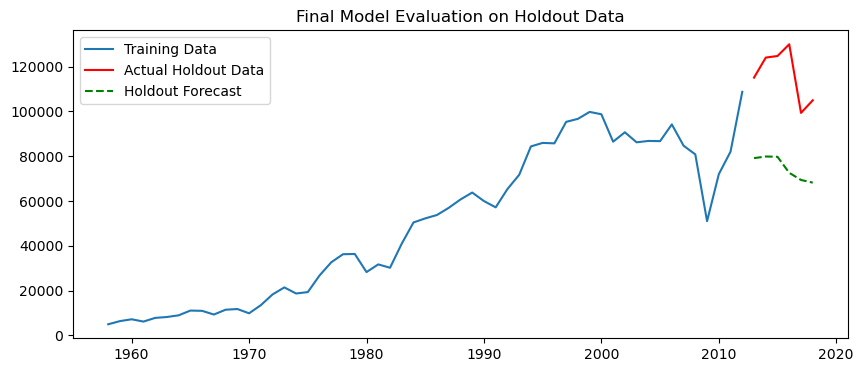

In [82]:
import matplotlib.pyplot as plt
# Plot Predictions vs Actual
plt.figure(figsize=(10, 4))
plt.plot(train["ds"], train["y"].astype(float), label="Training Data")
plt.plot(val["ds"], val["y"].astype(float), label="Actual Holdout Data", color="red")
plt.plot(val["ds"], forecast_df["LSTM_12-lo-80"].values[:val["y"].shape[0]], label="Holdout Forecast", linestyle="dashed", color="green")
plt.title("Final Model Evaluation on Holdout Data")
plt.legend()
plt.show()